# Terminal Expression Matrix

Matrix of cell x gene for cells in terminal states.

Inputs:
1. Seurat RNA object
2. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
3. ATAC->RNA cluster transfer tsv (should be same cluster IDs as old IDs)

In [2]:
library(Seurat)
library(ggplot2)
library(reshape2)
library(viridis)
library(scales)
library(patchwork)

## Load Inputs
### Seurat Object

In [3]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/seurat.rds")
rna$tech = "rna"

### Cluster Configs

In [6]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)


rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially-reprogrammed,10


In [7]:
# slight tweak for long name
cluster_config[9, "description"] = "Partial"

### ATAC-RNA Label Transfer

In [8]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20210725_n59378//atac.20210717_n62599.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,1,1
AAACCCAAGTGCCAGA-1,D0,1,1
AAACCCACACCATTCC-1,D0,1,1
AAACCCACACGCGTCA-1,D0,1,1
AAACCCAGTCCATAGT-1,D0,1,1
AAACCCAGTTATTCTC-1,D0,1,1


In [9]:
rna@meta.data['atac_transfer_cluster'] = factor(atac.rna.label$atac_new_cluster)
head(rna@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mt,qc_pass,selected,percent.oskm,RNA_snn_res.1.5,seurat_clusters,RNA_snn_res.2,tech,atac_transfer_cluster
,<fct>,<dbl>,<int>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>,<fct>
AAACCCAAGAGTGACC-1,scRNA-reprog,13707,3472,D0,4.238710,TRUE,0,0.007295542,6,13,13,rna,1
AAACCCAAGTGCCAGA-1,scRNA-reprog,12326,3497,D0,5.719617,TRUE,1,0.016225864,6,13,13,rna,1
AAACCCACACCATTCC-1,scRNA-reprog,14442,3996,D0,4.216867,TRUE,0,0.013848497,6,32,32,rna,1
AAACCCACACGCGTCA-1,scRNA-reprog,8813,2793,D0,4.788381,TRUE,0,0.011346874,0,2,2,rna,1
AAACCCAGTCCATAGT-1,scRNA-reprog,12115,3263,D0,6.009080,TRUE,0,0.000000000,0,2,2,rna,1
AAACCCAGTTATTCTC-1,scRNA-reprog,14310,4524,D0,5.688330,TRUE,1,0.006988120,11,11,11,rna,1


In [10]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    guides(colour = guide_legend(title="Day",
         override.aes = list(shape=16, alpha=1, size=4)))
}

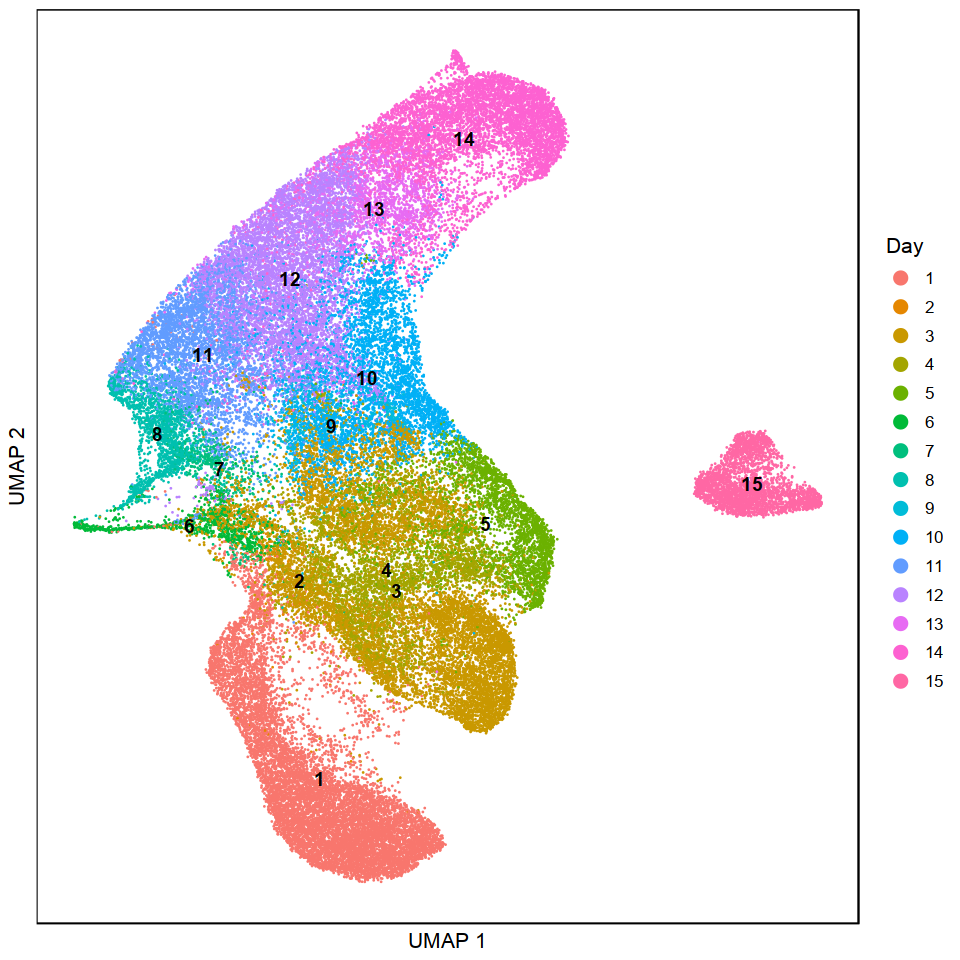

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)

u1 = data.frame(Embeddings(rna, reduction='umap'))$UMAP_1
u2 = data.frame(Embeddings(rna, reduction='umap'))$UMAP_2
cl = factor(atac.rna.label$atac_new_cluster)
plot_dimred(u1, u2, cl) +
geom_text(data=data.frame(aggregate(data.frame(umap.1=u1,umap.2=u2), list(cl), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold") 

## Gene List
From Clustering Variable Genes (From FineClustering.ipynb)

In [15]:
ker_genes = as.vector(read.table("../../analysis/20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx7.txt")$V1)

In [16]:
ker_genes[grep("KRT",ker_genes)]

[1] "KRT6A" "KRT13" "KRT14" "KRT16" "KRT17"

In [56]:
ipsc_genes = c(as.vector(read.table("../../analysis/20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx12.txt")$V1),
               as.vector(read.table("../../analysis/20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx13.txt")$V1))

In [59]:
ipsc_genes[grep("DPPA",ipsc_genes)]

[1] "DPPA2" "DPPA5" "DPPA3"

In [168]:
# partial_genes = as.vector(read.table("../../analysis/20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx9.txt")$V1)

In [169]:
# partial_genes[grep("COL",partial_genes)]

In [100]:
nonreprog_genes = as.vector(read.table("../../analysis/20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx5.txt")$V1)

In [101]:
nonreprog_genes[grep("COL",nonreprog_genes)]

[1] "COL7A1"  "COL1A2"  "COL22A1" "COL15A1" "COL5A1"  "COL4A1"  "COL4A2" 
 [8] "COL1A1"  "COL5A3"  "COL18A1" "COL6A2"

## Plotting

In [171]:
FIBR_CLUS = 1
NONREPROG_CLUS = 5
KER_CLUS = 6
IPSC_CLUS = 15

In [172]:
# shuffle genes within categories 
# gene_list = c(sample(rownames(nonreprog_markers)), 
#               sample(rownames(ker_markers)), 
#               sample(rownames(preipsc_markers)))

gene_list = c(nonreprog_genes,
              ker_genes,
             ipsc_genes)

gene_matrix = rna@assays$RNA@data[gene_list,]

In [173]:
sum(is.na(gene_matrix))

[1] 0

In [174]:
dim(gene_matrix)

[1]  1121 59378

In [175]:
znorm_gene_matrix = as.matrix(t(scale(t(as.matrix(gene_matrix)))))
head(znorm_gene_matrix)

,AAACCCAAGAGTGACC-1,AAACCCAAGTGCCAGA-1,AAACCCACACCATTCC-1,AAACCCACACGCGTCA-1,AAACCCAGTCCATAGT-1,AAACCCAGTTATTCTC-1,AAACCCAGTTGTAGCT-1,AAACCCATCAGACATC-1,AAACCCATCCGTAGGC-1,AAACCCATCGTTAGAC-1,⋯,TTTGATCAGTCAGGGT-9,TTTGATCGTCGCACAC-9,TTTGGAGAGCTCGTGC-9,TTTGGAGTCGACTCCT-9,TTTGGAGTCTATGTGG-9,TTTGGTTCACATCCCT-9,TTTGGTTGTTGCCTAA-9,TTTGGTTTCTCTTAAC-9,TTTGTTGGTAGTGTGG-9,TTTGTTGTCCGTAGTA-9
TNFRSF4,-0.1201901,-0.1201901,-0.1201901,-0.1201901,-0.1201901,-0.1201901,-0.1201901,-0.1201901,-0.1201901,-0.1201901,⋯,-0.12019011,-0.12019011,-0.1201901,-0.1201901,-0.12019011,-0.1201901,-0.1201901,-0.1201901,-0.12019011,-0.1201901
GPR153,-0.2948488,-0.2948488,-0.2948488,-0.2948488,2.8946381,-0.2948488,-0.2948488,-0.2948488,-0.2948488,-0.2948488,⋯,-0.29484881,-0.29484881,-0.2948488,-0.2948488,-0.29484881,-0.2948488,-0.2948488,-0.2948488,-0.29484881,-0.2948488
ERRFI1,-0.4580687,1.1900529,1.9532832,-0.4580687,-0.4580687,-0.4580687,-0.4580687,-0.4580687,-0.4580687,-0.4580687,⋯,2.86979846,-0.45806873,-0.4580687,-0.4580687,-0.45806873,-0.4580687,-0.4580687,-0.4580687,-0.45806873,-0.4580687
MFAP2,0.2009658,0.2862332,-0.8106752,-0.8106752,-0.8106752,0.1678494,0.8419987,-0.8106752,-0.8106752,-0.8106752,⋯,-0.81067519,1.26839658,-0.8106752,-0.8106752,0.09651717,-0.8106752,1.0855421,0.9526052,-0.81067519,-0.8106752
ID3,-0.1225091,0.7125176,0.8261203,1.0154879,-0.7895589,-0.1443452,-0.7895589,1.2060939,-0.7895589,1.6475394,⋯,-0.09244161,0.07942064,-0.7895589,-0.7895589,-0.78955894,2.0537967,-0.2192276,-0.7895589,-0.01085845,-0.7895589
SERINC2,0.3814152,2.4581469,0.3394057,0.7888164,1.2080301,1.5088007,-0.6791381,0.4907823,1.9836985,-0.6791381,⋯,-0.67913814,-0.67913814,-0.6791381,-0.6791381,-0.67913814,-0.6791381,-0.6791381,-0.6791381,0.55893030,0.0759782


In [176]:
# sample equal number of barcodes from each cluster
fibr_barcodes = colnames(rna)[rna$atac_transfer_cluster==FIBR_CLUS]
nonreprog_barcodes = sample(colnames(rna)[rna$atac_transfer_cluster==NONREPROG_CLUS])
ker_barcodes = sample(colnames(rna)[rna$atac_transfer_cluster==KER_CLUS])
ipsc_barcodes = sample(colnames(rna)[rna$atac_transfer_cluster==IPSC_CLUS])

sample_each = min(length(fibr_barcodes), length(nonreprog_barcodes), length(ker_barcodes), length(ipsc_barcodes))

fibr_barcodes = sample(fibr_barcodes, sample_each)
nonreprog_barcodes = sample(nonreprog_barcodes, sample_each)
ker_barcodes = sample(ker_barcodes, sample_each)
ipsc_barcodes = sample(ipsc_barcodes, sample_each)

barcodes = c(fibr_barcodes, # fibroblasts for control
            nonreprog_barcodes,
            ker_barcodes,
            ipsc_barcodes)
length(barcodes)

[1] 3736

In [177]:
to_plot_matrix = znorm_gene_matrix[, barcodes]
dim(to_plot_matrix)

[1] 1121 3736

In [178]:
mean(to_plot_matrix)

[1] 0.1103415

In [179]:
# head(preipsc_markers)

In [180]:
ker_genes[grep("GJA",ker_genes)]

character(0)

In [181]:
options(repr.plot.width = 8, repr.plot.height = 10)

heatmap <- ggplot(melt(to_plot_matrix[,seq(1,ncol(to_plot_matrix), 10)])) +
# geom_tile() +
geom_raster(aes(x=Var2, y=Var1, fill=value)) +
scale_fill_gradient2(high="tomato", 
                     mid="black", 
                     low="blue", 
                     name= "Z-score",
                     limits=c(-1, 2), oob=squish,
                     guide = guide_colourbar(direction = "horizontal",                                             
                                             title.position = "top")) +
xlab("Cells") + ylab(NULL) +
# scale_y_discrete(breaks=GENES_TO_LABEL, position = "right") + 
theme(axis.text.x = element_blank(),
      axis.text.y= element_blank(), #element_text(size=15),
      axis.ticks.y=element_blank(),
      axis.ticks.x=element_blank(),
      axis.title.x = element_text(size=20),
     legend.position = "bottom",
     legend.justification="right",
     legend.margin= margin(-20,0,0,0, "pt")) 

In [182]:
fibr_end = 10*length(fibr_barcodes)/length(barcodes)
nonreprog_end = fibr_end + 10*length(nonreprog_barcodes)/length(barcodes)
ker_end = nonreprog_end + 10*length(ker_barcodes)/length(barcodes)

PAD = 0.05
THICK=2
TEXTSZ=5.5
TEXTY=7
SEGY = 1.5

top_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0,10)) + # this let's use 0-10 on y axis to place items
                annotate("segment", x = 0, xend = fibr_end-PAD, y = SEGY, yend = SEGY, size=THICK, 
                         colour = cluster_config[cluster_config$new_cluster==FIBR_CLUS, "colour"]) +
                annotate("text", x = fibr_end/2, y = TEXTY, size=TEXTSZ, 
                         label = sprintf("%s\n(%d)",
                                        cluster_config[cluster_config$new_cluster==FIBR_CLUS, "description"],
                                        FIBR_CLUS)) +

                annotate("segment", x = fibr_end+PAD, xend = nonreprog_end-PAD, y = SEGY, yend = SEGY, size=THICK, 
                         colour = cluster_config[cluster_config$new_cluster==NONREPROG_CLUS, "colour"]) +
                annotate("text", x = (fibr_end+nonreprog_end)/2, y = TEXTY, size=TEXTSZ, 
                         label = sprintf("%s\n(%d)",
                                        cluster_config[cluster_config$new_cluster==NONREPROG_CLUS, "description"],
                                        NONREPROG_CLUS)) +

                annotate("segment", x = nonreprog_end+PAD, xend = ker_end-PAD, y = SEGY, yend = SEGY, size=THICK,
                         colour = cluster_config[cluster_config$new_cluster==KER_CLUS, "colour"]) +
                annotate("text", x = (nonreprog_end + ker_end)/2, y = TEXTY, size=TEXTSZ, 
                         label = sprintf("%s\n(%d)",
                                        cluster_config[cluster_config$new_cluster==KER_CLUS, "description"],
                                        KER_CLUS)) +

                annotate("segment", x = ker_end+PAD, xend = 10, y = SEGY, yend = SEGY, size=THICK,
                        colour = cluster_config[cluster_config$new_cluster==IPSC_CLUS, "colour"]) +
                annotate("text", x = (ker_end+10)/2, y = TEXTY, size=TEXTSZ,
                         label = sprintf("%s\n(%d)",
                                        cluster_config[cluster_config$new_cluster==IPSC_CLUS, "description"],
                                        IPSC_CLUS))

In [183]:
nonreprog_anno = c("MMP11", "FN1", "LUM", "COL5A1", "COL1A1") #, "MMP14")
ker_anno = c("KRT14", "KRT6A", "KRT16", "FLG", "S100A2") #, "CST6")
ipsc_anno = c("DPPA5","APOE","DNMT3B","NODAL","TET1", "MT1F", "DPPA2", "DPPA3", "ZFP42", "OTX2") #, "CTCFL")

# list those not in gene_list --> manually remove them
nonreprog_anno[!nonreprog_anno %in% gene_list]
ker_anno[!ker_anno %in% gene_list]
ipsc_anno[!ipsc_anno %in% gene_list]

character(0)

[1] "S100A2"

character(0)

In [184]:
# replace with markers if using those instead of genes
nonreprog_gene_end = 10*length(nonreprog_genes)/length(gene_list) 
ker_gene_end = nonreprog_gene_end + 10*length(ker_genes)/length(gene_list)

genes_anno_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0.4,9.6)) + # this let's use 0-10 on y axis to place items
                annotate("segment", x = 0, xend = 10, y = 0, yend = 0, size=0.5, linetype="dashed", colour = "black") +
                annotate("segment", x = 0, xend = 10, y = nonreprog_gene_end, yend = nonreprog_gene_end, size=0.5, linetype="dashed", colour = "black") +
                annotate("segment", x = 0, xend = 10, y = ker_gene_end, yend = ker_gene_end, size=0.5, linetype="dashed", colour = "black") +
                annotate("segment", x = 0, xend = 10, y = 10, yend = 10, size=0.5, linetype="dashed", colour = "black") 

nonreprog_anno_to_plot = as.character(sort(factor(nonreprog_anno[nonreprog_anno %in% gene_list], 
                                     levels=gene_list)))
ker_anno_to_plot = as.character(sort(factor(ker_anno[ker_anno %in% gene_list], 
                                     levels=gene_list)))
ipsc_anno_to_plot = as.character(sort(factor(ipsc_anno[ipsc_anno %in% gene_list], 
                                     levels=gene_list)))

GENE_TEXTSZ = 5
XOFF = 1
# add genes (ordered by actual order in plot)
for (x in seq(length(nonreprog_anno_to_plot))) {
    genes_anno_plot = genes_anno_plot + annotate("text", 
                                                 x = XOFF, 
                                                 y = nonreprog_gene_end*((x-0.5)/length(nonreprog_anno_to_plot)),
                                                 size=GENE_TEXTSZ,
                                                 label = nonreprog_anno_to_plot[x],
                                                hjust=0) 
}

for (x in seq(length(ker_anno_to_plot))) {
    genes_anno_plot = genes_anno_plot + annotate("text", 
                                                 x = XOFF, 
                                                 y = nonreprog_gene_end + (ker_gene_end-nonreprog_gene_end)*((x-0.5)/length(ker_anno_to_plot)),
                                                 size=GENE_TEXTSZ,
                                                 label = ker_anno_to_plot[x],
                                                hjust=0) 
}

for (x in seq(length(ipsc_anno_to_plot))) {
    genes_anno_plot = genes_anno_plot + annotate("text", 
                                                 x = XOFF, 
                                                 y = ker_gene_end + (10-ker_gene_end)*((x-0.5)/length(ipsc_anno_to_plot)),
                                                 size=GENE_TEXTSZ,
                                                 label = ipsc_anno_to_plot[x],
                                                hjust=0) 
}

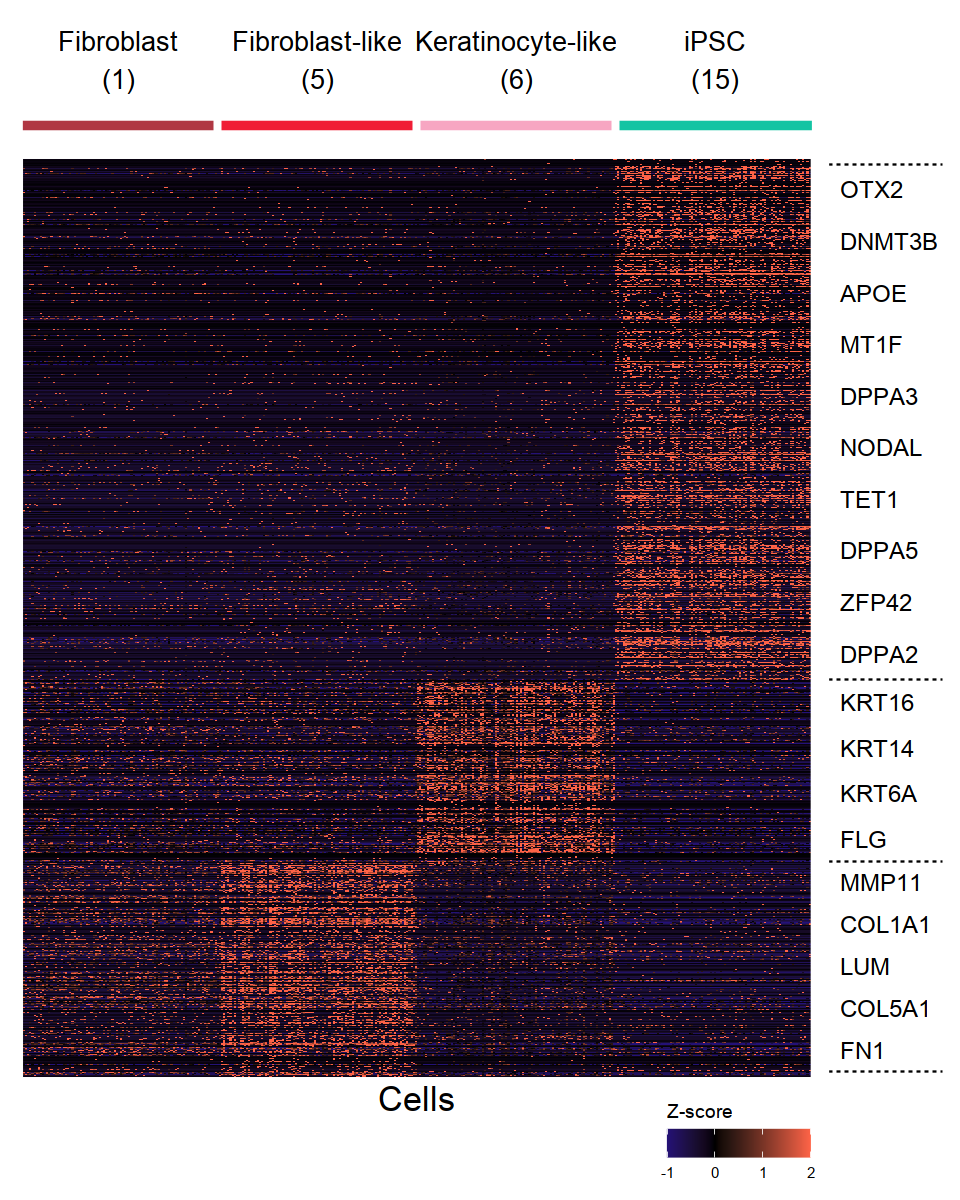

In [185]:
options(repr.plot.width = 8, repr.plot.height = 10)

heatmap_w_top_anno = wrap_plots(top_annotate_plot,
                                heatmap,
                                heights=c(1,7))

genes_anno_w_padding = wrap_plots(plot_spacer(),
                                 genes_anno_plot,
                                 heights=c(1,7))

plot_w_genes = wrap_plots(heatmap_w_top_anno,
                         genes_anno_w_padding,
                         widths=c(7,1))

plot_w_genes

In [ ]:
ggsave(plot_w_genes, file=sprintf("./subfigs/%s_terminal_expression_matrix.pdf",
                                   format(Sys.Date(), "%Y%m%d")),
      height=10, width=8, useDingbats=F)

In [ ]:
saveRDS(plot_w_genes, file=sprintf("./subfigs/%s_terminal_expression_matrix.rds",
                                   format(Sys.Date(), "%Y%m%d")))

---

In [122]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.0.0   scales_1.1.0      viridis_0.5.1     viridisLite_0.3.0
[5] reshape2_1.4.4    ggplot2_3.3.3     Seurat_3.1.5     

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RColorBrewer_1.1-2  httr_1.4.1          repr_1.1.0 

Code below not used.

## Marker Genes

In [ ]:
ker_markers = FindMarkers(rna, 
                          only.pos = T, 
                          ident.1 = 6, 
                          group.by = "atac_transfer_cluster",
                          min.pct = 0.05, 
                          logfc.threshold=0.5)

In [ ]:
ker_markers = ker_markers[ker_markers$p_val_adj<0.01, ]

In [ ]:
rownames(ker_markers)[grep("KLK", rownames(ker_markers))]

In [ ]:
dim(ker_markers)

In [ ]:
rownames(ker_markers)

In [104]:
tail(ker_markers)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CTSD,2.150966e-104,0.7949677,0.825,0.760,5.943549e-100
CCL5,1.537249e-74,0.5851525,0.078,0.024,4.247728e-70
ASMTL,1.462311e-53,0.5146201,0.290,0.185,4.040659e-49
PTP4A3,8.121154e-25,0.5467630,0.207,0.150,2.244037e-20
ABCA7,3.853800e-15,0.7428003,0.071,0.043,1.064882e-10
NSG1,6.217513e-10,0.6032463,0.216,0.190,1.718023e-05


In [84]:
preipsc_markers = FindMarkers(rna, 
                          only.pos = T, 
                          ident.1 = 16, 
                          group.by = "atac_transfer_cluster",
                          min.pct = 0.1, 
                          logfc.threshold=0.5)

In [85]:
preipsc_markers = preipsc_markers[preipsc_markers$p_val_adj<0.01, ]

In [86]:
dim(preipsc_markers)

[1] 150   5

In [103]:
rownames(preipsc_markers)[grep("NANOG", rownames(preipsc_markers))]

[1] "NANOG"

In [88]:
head(preipsc_markers)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
APOE,0,2.019941,0.999,0.391,0
MT1H,0,1.918306,0.986,0.252,0
LINC01356,0,1.651801,0.861,0.039,0
MT1G,0,1.644463,0.998,0.382,0
ALPG,0,1.627576,0.700,0.051,0
NLRP7,0,1.602949,0.975,0.113,0


In [89]:
nonreprog_markers = FindMarkers(rna, 
                          only.pos = T, 
                          ident.1 = 5, 
                          group.by = "atac_transfer_cluster",
                          min.pct = 0.1, 
                          logfc.threshold=0.5)

In [90]:
nonreprog_markers = nonreprog_markers[nonreprog_markers$p_val_adj<0.01, ]

In [91]:
dim(nonreprog_markers)

[1] 168   5

In [92]:
rownames(nonreprog_markers)[grep("TET", rownames(nonreprog_markers))]

character(0)

In [117]:
head(nonreprog_markers, 10)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MMP11,0,3.019928,0.868,0.115,0
TIMP3,0,2.467053,0.929,0.404,0
IFI27,0,2.097551,0.660,0.355,0
IGFBP7,0,2.061709,0.916,0.286,0
FN1,0,2.024147,1.000,0.777,0
CST1,0,1.901588,0.475,0.051,0
COL1A1,0,1.867359,1.000,0.770,0
COL1A2,0,1.603873,1.000,0.845,0
IFI6,0,1.572967,0.689,0.288,0


In [95]:
write.table(rownames(ker_markers), "tmp.txt", quote=F, row.names=F, col.names=F)

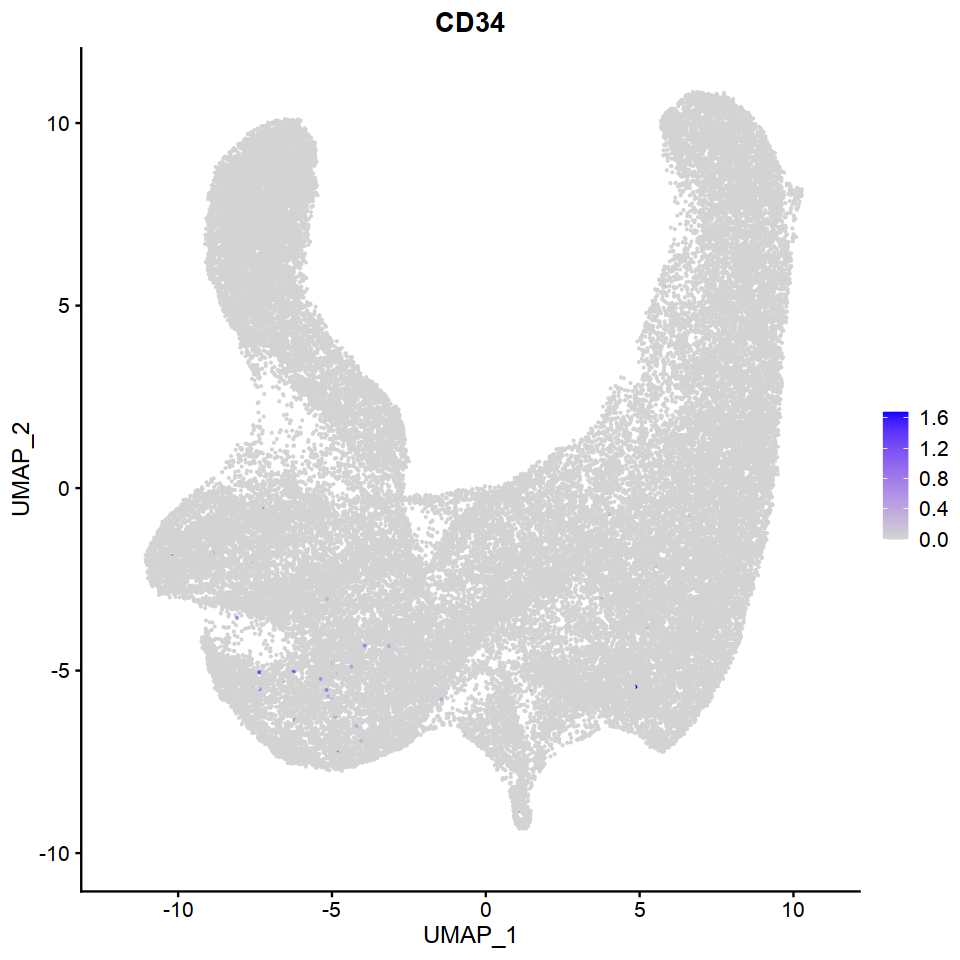

In [116]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna, features = c("CD34"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]